In [1]:
import os
from matplotlib import pylab as plt
from os import path
from numpy import array, maximum, minimum, median
import numpy

### Set plotting themes

In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=(20,5))

### Set plotting globals

In [3]:
N = 24
seeds = [i for i in range(1, 4)]
steps = [(i + 1) * 5000 for i in range(N)]

### Save target lane results

In [11]:
tls = [1.0]
lls = [0.0, 0.1, 0.2]
success_tl = list(list(list(list() for seed in seeds) for tl in tls) for ll in lls)
performance_path_tl = '/misc/vlgscratch4/LecunGroup/nvidia-collab/yairschiff/pytorch-PPUU/models_learned_cost/planning_results'
name_tl = 'MPUR-policy-deterministic-model=vae-zdropout=0.5-nfeature=256-bsize=6-npred=30-ureg=0.05-lambdal={ll}' + \
       '-lambdaa=0.0-gamma=0.99-lrtz=0.0-updatez=0-inferz=False-learnedcost=True-lambdatl={tl}' + \
       '-seed={seed}-novaluestep{step}.model.log'

for i, ll in enumerate(lls):
    for j, tl in enumerate(tls):
        for seed in seeds:
            for step in steps:
                file_name = path.join(performance_path_tl, name_tl.format(ll=ll, tl=tl, seed=seed, step=step))
                if os.path.isfile(file_name):
                    with open(file_name) as f:
                        success_tl[i][j][seed - 1].append(float(f.readlines()[-1].split()[-1]))
                else:
                    success_tl[i][j][seed - 1].append(None)

### Plot target lane results

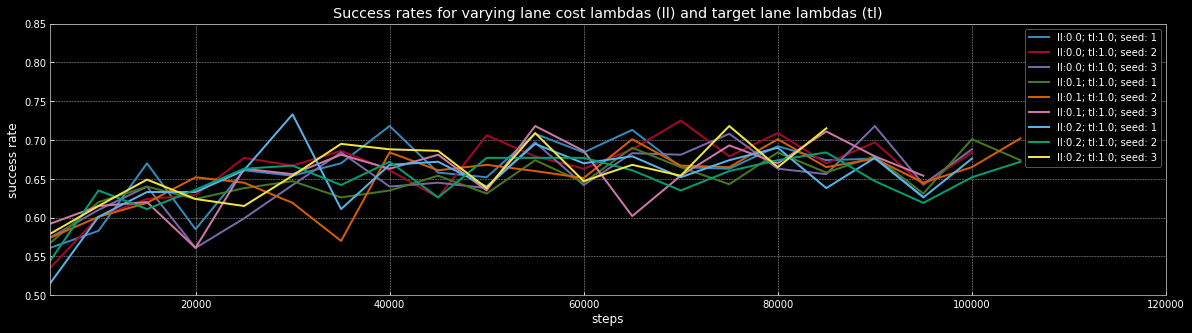

In [21]:
# Plot target lane results
if success_tl[0][0][0][0] is None:
    for i, ll in enumerate(lls):
        for j, tl in enumerate(tls):
            for seed in seeds: 
                plt.plot(steps[1::2], success_tl[i][j][seed - 1][1::2], label=f'll:{ll}; tl:{tl}; seed: {seed}')
else:
    for i, ll in enumerate(lls):
        for j, tl in enumerate(tls):
            for seed in seeds:
                plt.plot(steps, success_tl[i][j][seed - 1], label=f'll:{ll}; tl:{tl}; seed: {seed}')
plt.grid(True)
plt.xlabel('steps')
plt.ylabel('success rate')
plt.title('Success rates for varying lane cost lambdas (ll) and target lane lambdas (tl)')
plt.legend()
plt.ylim([0.50, 0.85])
plt.xlim([5_000, 120_000]);

### Save baseline results

In [15]:
performance_path_bl = '/misc/vlgscratch4/LecunGroup/nvidia-collab/yairschiff/pytorch-PPUU/' + \
                      'models_baseline/planning_results'
name_bl = 'MPUR-policy-deterministic-model=vae-zdropout=0.5-nfeature=256-bsize=6-npred=30-ureg=0.05-lambdal=0.2' + \
          '-lambdaa=0.0-gamma=0.99-lrtz=0.0-updatez=0-inferz=0-learnedcost=False' + \
          '-seed={seed}-novaluestep{step}.model.log'
success_bl = list(list() for seed in seeds)
for seed in seeds:
    for step in steps:
        file_name = path.join(performance_path_bl, name_bl.format(seed=seed, step=step))
        if os.path.isfile(file_name):
            with open(file_name) as f:
                success_bl[seed - 1].append(float(f.readlines()[-1].split()[-1]))
        else:
            success_bl[seed - 1].append(None)

### Plot target lane vs. baseline results

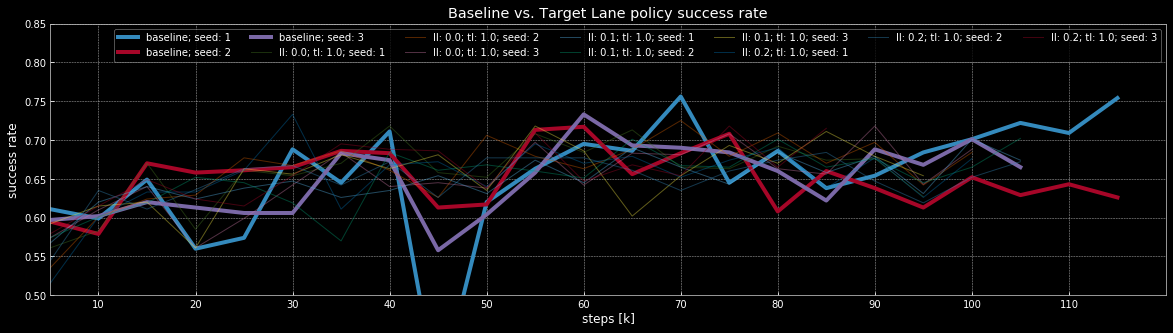

In [19]:
# Plot baseline
for seed in seeds:
    plt.plot(
        array(steps) / 1e3, success_bl[seed - 1],
        label=f'baseline; seed: {seed}',
        alpha=1,
        linewidth=4
    )
# Plot target lane
for i, ll in enumerate(lls):
    for j, tl in enumerate(tls):
        for seed in seeds:
            plt.plot(
                array(steps) / 1e3, success_tl[i][j][seed - 1],
                label=f'll: {ll}; tl: {tl}; seed: {seed}',
                alpha=0.4,
                linewidth=1
            )
plt.grid(True)
plt.xlabel('steps [k]')
plt.ylabel('success rate')
plt.legend(ncol=7)
plt.ylim([0.50, 0.85])
plt.xlim([5, 120])
plt.title('Baseline vs. Target Lane policy success rate')
plt.xticks(range(10, 100 + 20, 10));

# plt.savefig('Stc-vs-dtr-success_rate.png', bbox_inches = 'tight')

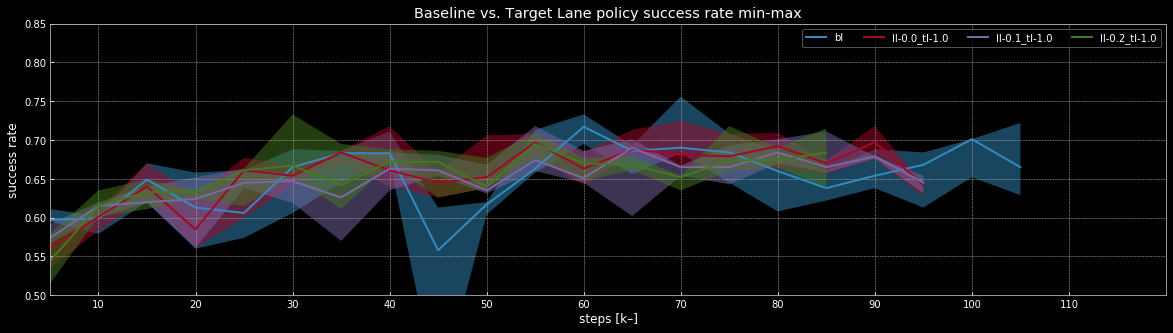

In [20]:
# Gather baseline plot elements
names = ['bl']
N_arr = {'bl': min([sum(x is not None for x in sbl) for sbl in success_bl])}
steps_arr = {'bl': steps[:N_arr['bl']]}
success_arr = {'bl': array([sbl[:N_arr['bl']] for sbl in success_bl])}

# Gather target lane plot elements
for i, ll in enumerate(lls):
    for j, tl in enumerate(tls):
        name = f'll-{ll}_tl-{tl}'
        names.append(name)
        N_arr[name] = min([sum(x is not None for x in stl) for stl in success_tl[i][j]])
        steps_arr[name] = steps[:N_arr[name]]
        success_arr[name] = array([stl[:N_arr[name]] for stl in success_tl[i][j]])
# stats = ('min', 'max', 'median')

for k in names:
    plt.plot(
        array(steps_arr[k]) / 1e3, numpy.median(success_arr[k], 0),
        label=f'{k}',
        linewidth=2,
    )
for k in names:
    plt.fill_between(
        array(steps_arr[k]) / 1e3, success_arr[k].min(0), success_arr[k].max(0),
        alpha=.5,
    )
plt.grid(True)
plt.xlabel('steps [k–]')
plt.ylabel('success rate')
plt.legend(ncol=7)
plt.ylim([0.50, 0.85])
plt.xlim([5, 120])
plt.title('Baseline vs. Target Lane policy success rate min-max')
plt.xticks(range(10, 100 + 20, 10));

# plt.savefig('Rgr-vs-hrd-success_rate-min-max.png', bbox_inches = 'tight')